# Sentiment Analysis using Airline Tweets
Author: Matthew Huh

<div class="alert alert-block alert-warning">
Note: The visuals for this project do not render correctly on Github; if you would like to view the presentation the way it was meant to be seen, please click on the following link.

http://nbviewer.jupyter.org/github/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Sentiment%20Analysis%20using%20Airline%20Tweets.ipynb
</div>

## Introduction

Corporations, like airlines, should care about what their customers have to say about them, especially if customers are able to take their money to another competitor. I’ll be evaluating the comments by what types of comments people are leaving, and if that is viewed positively, negatively, or somewhere in the middle. This feedback should allow companies to know what their customers think about them, and how people perceive them.

## About the Data

The training data has been obtained from crowdflower on Kaggle, and the testing set has been obtained via Twitter's API on more recent data. 

The training set has far more information as the data has been reviewed by people to determine the sentiment, and the rationale behind negative comments, something that may not be so easily extracted from the testing data set.

## Research Question

## Packages

## Source

https://www.kaggle.com/crowdflower/twitter-airline-sentiment


# To-do list

* Implement NLP methods (LSA, TF-IDF, LDA, NNMF, etc.)
* Run machine learning models
* Extract twitter data for testing data set

In [1]:
# Basic imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

C:\Users\mhuh22\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import the data
tweets = pd.read_csv("airline_tweets/Tweets.csv")

# Preview the dataset
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# View the size of the dataset
tweets.shape

(14640, 15)

This dataset has a bit more information than we actually need for this project. We definitely need the text information since that is what we are evaluating, the sentiment since that is what we are trying to measure, and the reason to determine what clusters of complaints people are encountering. As for the rest, they could have some impact on the outcome, but they are not what we are trying to measure so, we'll drop the rest before continuing in order to improve our runtimes.

In [4]:
# Drop columns that have no predictive power
tweets.drop(['tweet_id'], axis=1,inplace=True)

In [5]:
# Print unique airlines in the dataset
sorted(tweets['airline'].unique())

['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America']

In [6]:
# Describe unique occurences for each categorical variable
tweets.select_dtypes(include=['object']).nunique()

airline_sentiment             3
negativereason               10
airline                       6
airline_sentiment_gold        3
name                       7701
negativereason_gold          13
text                      14427
tweet_coord                 832
tweet_created             14247
tweet_location             3081
user_timezone                85
dtype: int64

## Data Visualization

In [7]:
# View distribution of tweets by sentiment 
# (Changing colors to red/gray/green would be nice)
trace = go.Pie(labels=tweets['airline_sentiment'].value_counts().index, 
              values=tweets['airline_sentiment'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Tweet Sentiment',
    height = 400,
    width = 500,
    autosize = False,
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename='cufflinks/simple')

In [8]:
# Plots the complaint reasons, and their frequency
# (It might be nice to somehow show how common each reason is for each airline)

# The input is the number of negative tweets by reason
data = [go.Bar(
    x = tweets.negativereason.value_counts().index,
    y = tweets.negativereason.value_counts(),
    opacity = 0.7
)]

# Create the layout
layout = go.Layout(
    title = 'Negative Tweets by Reason',
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data = data, layout = layout)
py.offline.iplot(fig, filename='cufflinks/simple')

In [9]:
# Show distribution of texts

trace1 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'negative'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Negative',
    marker = dict(color='rgba(200,0,0,.7)')
)

trace2 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'neutral'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Neutral',
    marker = dict(color='rgba(150,150,150,.7)')
)

trace3 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'positive'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Positive',
    marker = dict(color='rgba(0,200,0,.7)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Sentiment per airline (Totals)',
    barmode='group',
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='stacked-bar')

<div class="alert alert-block alert-warning">
For the above visual, please feel free to toggle the sentiment categories on the right.
</div>

### Class Imbalance

Based on the number of total tweets above, we can see that certain airlines don't have the same presence as others, namely Virgin America, which is a much smaller airline than the others in our dataset. In order to fix this issue, I will be upsampling the data so that all of the airlines will have an equal number of tweets.

In [10]:
# Count # of tweets for each airline
tweets.groupby(['airline']).size().sort_values(ascending = False)

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
dtype: int64

In [11]:
# Create temporary dataframe for all airlines to upsample and concatenate
tweets_united = tweets[tweets.airline=='United']
sample_size = len(tweets[tweets['airline']=='United'])

# Upsample all other airlines
tweets_usairways = resample(tweets[tweets.airline=='US Airways'], 
                            replace=True, n_samples=sample_size)
tweets_american = resample(tweets[tweets.airline=='American'], 
                           replace=True, n_samples=sample_size)
tweets_southwest = resample(tweets[tweets.airline=='Southwest'], 
                            replace=True, n_samples=sample_size)
tweets_delta = resample(tweets[tweets.airline=='Delta'], 
                        replace=True, n_samples=sample_size)
tweets_virgin = resample(tweets[tweets.airline=='Virgin America'], 
                         replace=True, n_samples=sample_size)

# Concatenate the individual dataframes
tweets = pd.concat([tweets_united, 
                   tweets_usairways, 
                   tweets_american, 
                   tweets_southwest,
                   tweets_delta,
                   tweets_virgin])

tweets = tweets.reset_index(drop=True)

# Count # of tweets for each airline to verify
tweets.groupby(['airline']).size()

airline
American          3822
Delta             3822
Southwest         3822
US Airways        3822
United            3822
Virgin America    3822
dtype: int64

In [12]:
# Show distribution of texts
# (Percentage of total tweets per airline would be nice)

trace1 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'negative'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Negative',
    marker = dict(color='rgba(200,0,0,.7)')
)

trace2 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'neutral'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Neutral',
    marker = dict(color='rgba(150,150,150,.7)')
)

trace3 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'positive'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Positive',
    marker = dict(color='rgba(0,200,0,.7)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Airline Sentiment (Percentage)',
    barmode='group',
    yaxis = dict(title='% of tweets')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='stacked-bar')

<div class="alert alert-block alert-warning">
For the above visual, please feel free to toggle the sentiment categories on the right.
</div>

## Text Cleaning

In [13]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [14]:
# Remove non-essential punctuation from the tweets
pd.options.display.max_colwidth = 200
tweets['text'] = tweets['text'].map(lambda x: text_cleaner(str(x)))
tweets['text'].head()

0                                                                                                                                @united thanks
1                                                                                   @united Thanks for taking care of that MR!! Happy customer.
2      @united still no refund or word via DM. Please resolve this issue as your Cancelled Flightled flight was useless to my assistant's trip.
3    @united Delayed due to lack of crew and now delayed again because there's a long line for deicing... Still need to improve service #united
4                                                                      @united thanks we filled it out. How's our luck with this? Is it common?
Name: text, dtype: object

In [15]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for tweet in tweets['text']:
    tweet = lemmatizer.lemmatize(tweet)

In [16]:
tweets[['airline_sentiment', 'text']].head()

,airline_sentiment,text
0,positive,@united thanks
1,positive,@united Thanks for taking care of that MR!! Happy customer.
2,negative,@united still no refund or word via DM. Please resolve this issue as your Cancelled Flightled flight was useless to my assistant's trip.
3,negative,@united Delayed due to lack of crew and now delayed again because there's a long line for deicing... Still need to improve service #united
4,positive,@united thanks we filled it out. How's our luck with this? Is it common?


In [17]:
# Modify values of sentiment to numerical values
# This block is useful before modelling, but it's pretty annoying right now
sentiment = {'negative': -1, 'neutral': 0, 'positive': 1}
tweets['airline_sentiment'] = tweets['airline_sentiment'].map(lambda x: sentiment[x])

# Wordcloud generation

In [18]:
# wordcloud = WordCloud(stopwords=stopwords, max_words=50, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()
    
# text = " ".join(tweet for tweet in airline_tweets['text'])

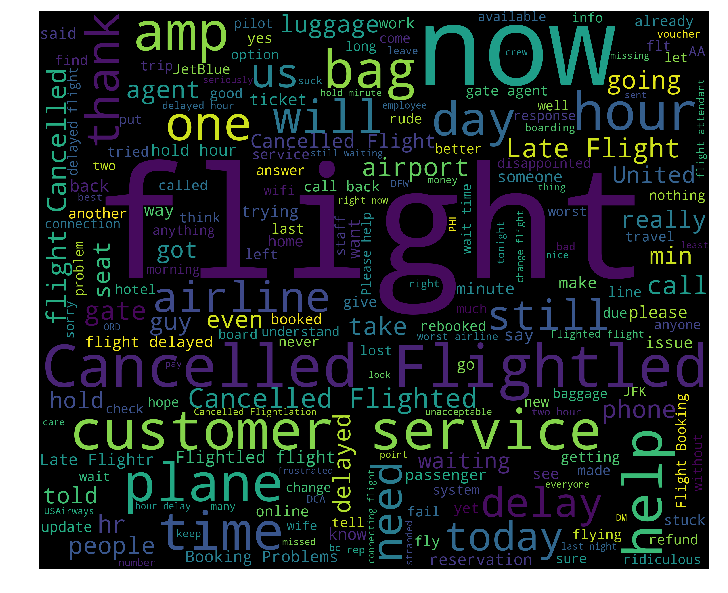

In [19]:
# Modify later?

df=tweets[tweets['airline_sentiment']==-1]
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Natural Lanuage Processing

In [20]:
## Creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(tweets['text'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 50

# Number of possible outcomes (3 = positive, neutral, negative)
ntopics = tweets['airline_sentiment'].nunique()

In [21]:
# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)

In [22]:
# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nnmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [23]:
# View top words identified by LSA and NNMF
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                    LSA                 NNMF
0         flight 667.48         flight 31.04
0         united 590.36      usairways 19.94
0    americanair 565.62    americanair 18.29
0      usairways 543.62      cancelled 16.61
0   southwestair 522.96         united 12.91
0  virginamerica 480.48   southwestair 11.03
0        jetblue 442.91      flightled 10.99
0         thanks 280.48  virginamerica 10.54
0           http 277.32           help 10.22
0           just 272.81            hold 9.53
0           help 254.19           hours 8.49
0      cancelled 252.58         service 7.59
0        service 251.63            just 7.53
0           time 217.74         flights 7.06
0       customer 211.26            need 6.61
0        flights 202.43             time 6.4
0           hold 188.91         customer 6.3
0          hours 184.97            hour 5.83
0           need 177.62         delayed 5.53
0          plane 168.94          thanks 5.32
0            amp 165.65           phone 5.15
0

In [24]:
# Create keyword set with top words identified by LSA
keywords = set(topwords['LSA'].str.split(' ', 0).str[0])

# New dataframe with just the text and query
sentences = tweets[['text', 'airline_sentiment']]

In [25]:
tweets.dropna(subset=['text'], inplace=True)

In [26]:
X = tweets['text']
y = tweets['airline_sentiment']

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# count_vectorizer = CountVectorizer(
#     analyzer="word", tokenizer=nltk.word_tokenize,
#     preprocessor=None, stop_words='english', max_features=None) 

from sklearn.feature_extraction.text import TfidfVectorizer

# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=5, 
                             max_features=500, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

Number of features: 500


# Modelling Phase

So, the tweets have been parsed and prepared for our models. We're trying to determine if it's possible to predict sentiment (a binary variable) so that means that we will require some classification models. As for which models to test, we will be using 
* Logistic Regression (a fast and simple model)
* Random Forest Ensemble (a powerful and scaleable model)
* Gradient Boosting Ensemble (a powerful, iterable model)

In [28]:
# Break: it's not time for modelling just yet!

break

SyntaxError: 'break' outside loop (<ipython-input-28-ebf1e4203944>, line 3)

In [34]:
# Testing the model

X_train = X_normal
X_test = normalize(X_test_tfidf)

In [ ]:
# # Size of graph
# plt.rcParams['figure.figsize'] = [10,5]

# # k means determine k
# distortions = []
# K = range(1,15)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(features)
#     kmeanModel.fit(features)
#     distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [35]:
# Logistic Regression Model

lr = LogisticRegression()
lr_train = cross_val_score(lr, X_train, y_train, cv=5, n_jobs=-1)
print('Logistic regression training score: {:.5f}(+/- {:.2f})\n'.format(lr_train.mean(), lr_train.std()*2))

lr_test = cross_val_score(lr, X_test, y_test, cv=5, n_jobs=-1)
print('Logistic regression testing score: {:.5f}(+/- {:.2f})\n'.format(lr_test.mean(), lr_test.std()*2))

Logistic regression score: 0.78016(+/- 0.02)

Logistic regression score: 0.74970(+/- 0.03)



In [36]:
# Random Forest Classifier Model

rfc = ensemble.RandomForestClassifier(n_jobs=-1)
rfc_train = cross_val_score(rfc, X_train, y_train, cv=5, n_jobs=-1)
print('Random forest classifier training score: {:.5f}(+/- {:.2f})\n'.format(rfc_train.mean(), rfc_train.std()*2))

rfc_test = cross_val_score(rfc, X_test, y_train, cv=5, n_jobs=-1)
print('Random forest classifier testing score: {:.5f}(+/- {:.2f})\n'.format(rfc_test.mean(), rfc_test.std()*2))

Random forest classifier score: 0.85953(+/- 0.01)

Random forest classifier score: 0.86063(+/- 0.01)



In [ ]:
# Gradient Boosting Model

gbc = ensemble.GradientBoostingClassifier()
gbc_train = cross_val_score(gbc, X_train, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier training score: {:.5f}(+/- {:.2f})\n'.format(gbc_train.mean(), gbc_train.std()*2))

gbc_test = cross_val_score(gbc, X_test, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier testing score: {:.5f}(+/- {:.2f})\n'.format(gbc_test.mean(), gbc_test.std()*2))

# Testing Set

Now, it's time to add our testing data set. What if we decide to look at more recent tweets from the same airline, or how about we also decide to look at other airlines that weren't even in our dataset? 

Enough with the hypotheticals. The next dataset is a collection of recent tweets containing the testing data that we want and while we won't be able to assess its accuracy since we don't have the correct values, we should be able to get a good idea of measuring sentiment analysis for other airlines with our training set.

In [ ]:
# Import the training dataset
tweets_test = pd.read_csv("airline_tweets/test_set.csv")

# Preview the data
tweets_test.head()